In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
def make_hello(N=1000, rseed=42):
    #Создаем рисунок с текстом "HELLO"; сохраняем его в формате PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold',
            size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    #Открываем этот PNG-файл и берем из него случайные точки
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]


(-0.11795497300761357,
 4.139300167128755,
 0.030904300267283337,
 1.0128816289391616)

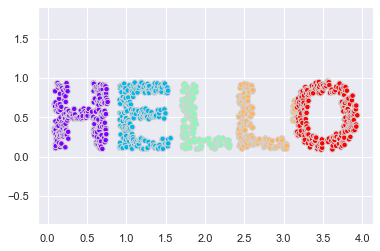

In [3]:
# Вызываем эту функцию и визуализируем полученные данные 

X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5), s=30,
                edgecolor='lightgray')
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal')

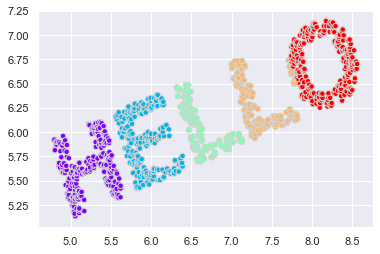

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

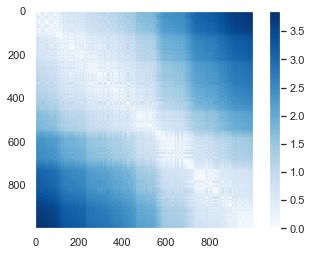

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

(-1.0381476116875685, 1.036854599911127, -2.063343682356385, 2.134135921390166)

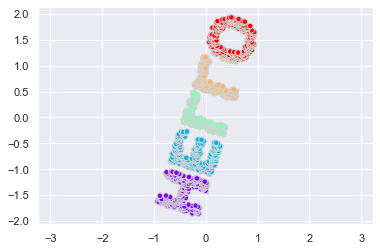

In [9]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed',
            random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal')

In [10]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3)
X3.shape

(1000, 3)

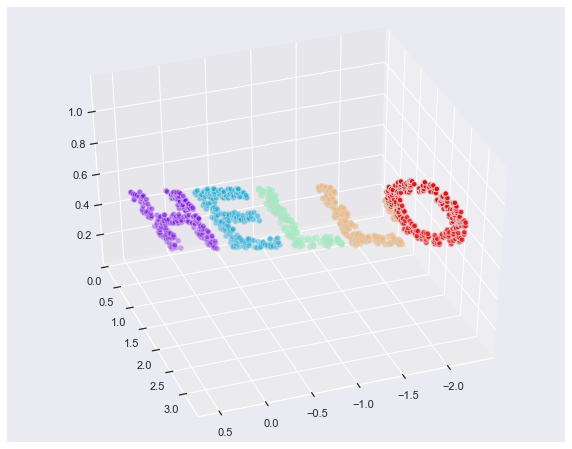

In [17]:
from mpl_toolkits import mplot3d
plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], **colorize)
ax.view_init(azim=70, elev=40)

(-1.0381476116875723,
 1.036854599911132,
 -2.0633436823563835,
 2.134135921390166)

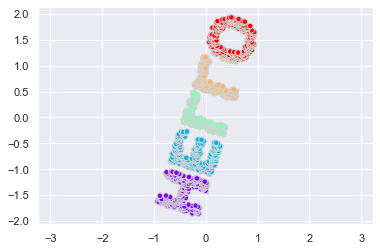

In [18]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal')

In [19]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

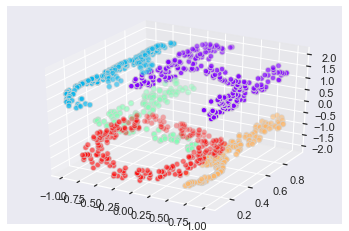

In [20]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize)

(-1.3895968332702398,
 1.2485049637653025,
 -2.3842270950711697,
 2.1886635892608113)

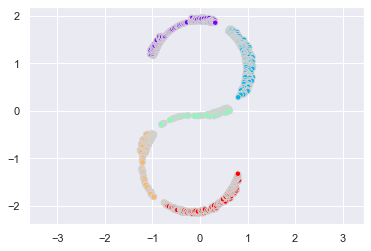

In [22]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal')

(0.15, -0.15)

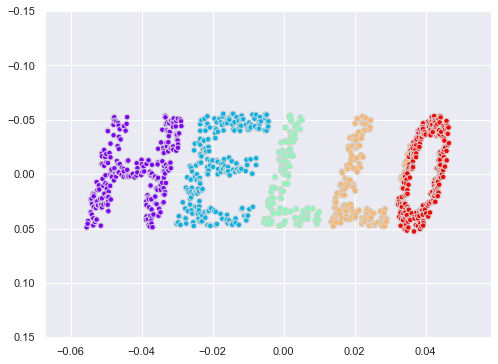

In [27]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2,
                               method='modified', eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15)

In [28]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person = 30)
faces.data.shape

(2370, 2914)

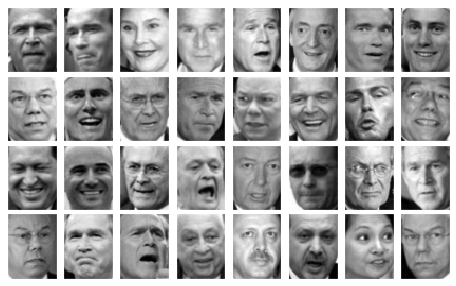

In [34]:
fig, ax = plt.subplots(4, 8,figsize=(8, 5), 
                       subplot_kw=dict(xticks=[], yticks=[]),
                       gridspec_kw=dict(hspace=0.05, wspace=0.05))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Text(0, 0.5, 'cumulative variance')

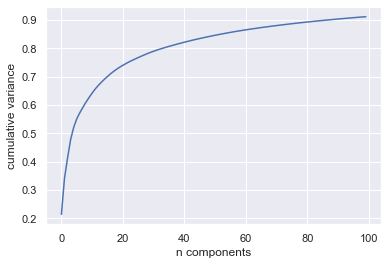

In [36]:
from sklearn.decomposition import PCA
model = PCA(100, svd_solver='randomized').fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components') #Число компонент
plt.ylabel('cumulative variance') #Интегральная дисперсия

In [38]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [41]:
from matplotlib import offsetbox
def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        show_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - show_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                #Не отображаем слишком близко расположеные точки
                continue
            show_images = np.vstack([show_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i],
                                                                      cmap=cmap),
                                                proj[i])
            ax.add_artist(imagebox)
            
    

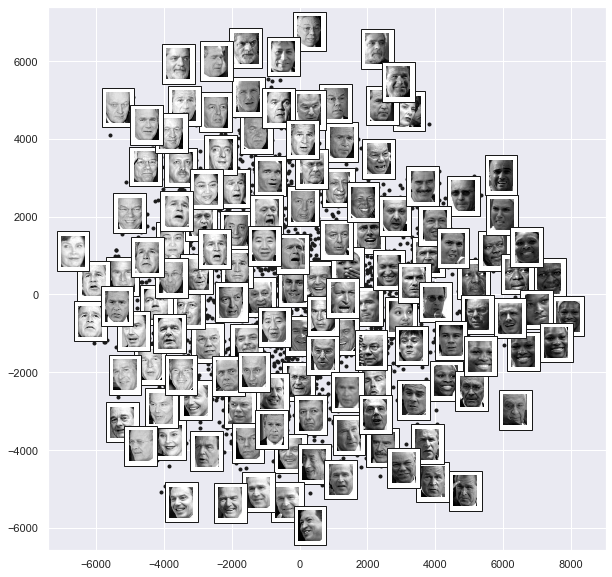

In [42]:
#Вызываем эту функцию и видим результат 

fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
               images=faces.images[:, ::2, ::2])

In [67]:
#fetch_mldata was deprecated in version 0.20 
#and will be removed in version 0.22. Please use fetch_openml.

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)


In [68]:
mnist.data.shape

(70000, 784)

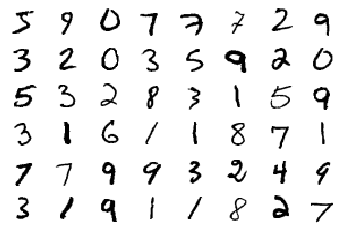

In [69]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28,28), cmap='gray_r')

In [75]:
#Блок для преобразования датасета MNIST_784 в "старую" форму MNIST_original

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

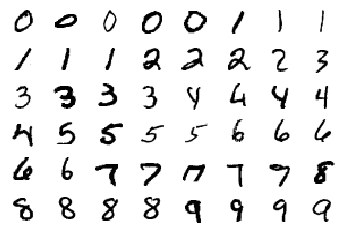

In [78]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28,28), cmap='gray_r')

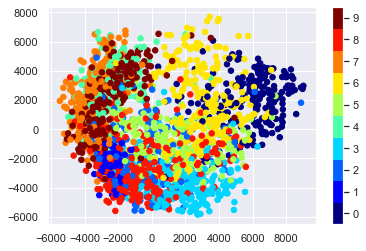

In [77]:
#Используем 1/30 часть данных:
#вычисления для полного набора занимают много времени
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, 
            cmap=plt.cm.get_cmap('jet', 10),
            s=30)
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/extmath.py:516: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


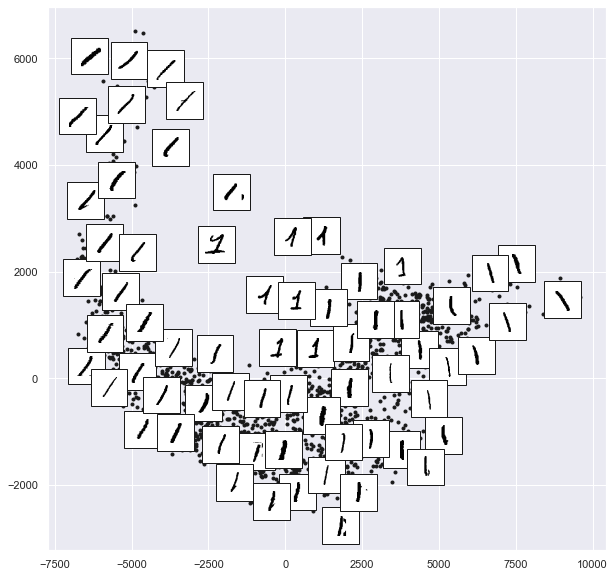

In [79]:
from sklearn.manifold import Isomap

#Выбираем для проекции 1/4 цифр "1"
data = mnist.data[mnist.target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')